In [1]:
from torchvision.transforms import Resize
from utils import *
from models.gan_load import make_style_gan2
from models.gan_load import make_proggan
from models.latent_deformator import LatentDeformator

from torchvision.utils import save_image
import numpy as np

## Configurations

In [2]:
gan_type = 'prog-gan'
num_directions = 512
shifts_r= 5
shifts_count=5
scale = Resize(64)

## Model Selection

In [3]:
if gan_type == 'StyleGAN2':
    config_gan = {"latent": 512, "n_mlp": 3,
                  "channel_multiplier": 8}
    G = Generator(size=64, style_dim=config_gan["latent"],n_mlp=config_gan["n_mlp"],
        small=True, channel_multiplier=config_gan["channel_multiplier"])
    G.load_state_dict(torch.load(opt.pretrained_gen_path))
    G.eval().to(device)
    for p in G.parameters():
        p.requires_grad_(False)
elif gan_type == 'StyleGAN2-Natural':
    G = make_style_gan2(1024,'models/pretrained/generators/StyleGAN2/stylegan2-ffhq-config-f.pt' , True)
elif gan_type == 'prog-gan':
    G = make_proggan('models/pretrained/generators/ProgGAN/100_celeb_hq_network-snapshot-010403.pth').cuda()

In [4]:
deformator = LatentDeformator(shift_dim=G.dim_z[0], input_dim=num_directions,
                              out_dim=G.dim_z[0], type='linear',random_init=True)
deformator.load_state_dict(torch.load('models/pretrained/deformators/ProgGAN/models/deformator_0.pt'))

<All keys matched successfully>

## Plot images

In [20]:
z = torch.randn(1, G.dim_z[0],G.dim_z[1],G.dim_z[2]).cuda()
shifted_images = []
for i,shift in enumerate(np.arange(-shifts_r, shifts_r, shifts_r / shifts_count)):
    latent_shift = deformator(one_hot(deformator.input_dim, shift,1))
    latent_shift = latent_shift.unsqueeze(2)
    latent_shift = latent_shift.unsqueeze(3)
    shifted_image = G(z+latent_shift.cuda())
    images_row = shifted_image.view(3,1024,1024)
    save_image(images_row,'images/'+str(i)+'.png')
    

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 3.95 GiB total capacity; 2.78 GiB already allocated; 47.19 MiB free; 2.81 GiB reserved in total by PyTorch)

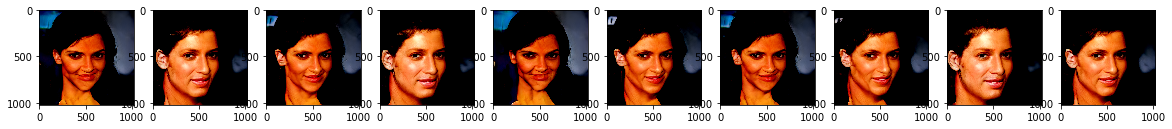

In [21]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('images/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)